# Introduction to NLP fundamentals in Tensorflow

NLP has the goal of deriving information out of natural langugae (could be sequences, text or speech).

Another common term for NLP problems is seuence to sequence problems (seq2seq).


## Check for GPU

In [1]:
# !nvidia-smi -L

## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-11-22 10:41:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-22 10:41:14 (53.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of tweets labelled as disaster or not disaster).

Dataset: https://www.kaggle.com/c/nlp-getting-started/data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# unzip data
unzip_data("nlp_getting_started.zip")

--2021-11-22 10:41:16--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-11-22 10:41:17 (102 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in. One way to do so would be to use python: https://realpython.com/read-write-files-python/

Another way to do this is to use pandas.

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][10]

'Three people died from the heat wave so far'

In [6]:
# shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
train_df_shuffled["text"].iloc[3]

'Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.'

In [8]:
# what does the dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# how many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# how many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target> 0 else "(not real disaster)")
  print(f"Text:{text}\n")
  print("----\n")

Target: 0 (not real disaster)
Text:it sure made an impact on me http://t.co/GS50DdG1JY

----

Target: 0 (not real disaster)
Text:@TheWesternGaz I'm sure the shop is deluged by local children wanting to buy it. Really?

----

Target: 0 (not real disaster)
Text:Despite the crippling anxiety and overwhelming panic attacks I'd say I'm fairly well-adjusted.

----

Target: 0 (not real disaster)
Text:This sale and demolition trend near Metrotown is sure resulting in some poorly maintained apartments. #burnaby #changefortheworse

----

Target: 0 (not real disaster)
Text:@thebriankrause leos ass just got metaphorically blown up again #PiperWearsThePants #charmed

----



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split


In [13]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [14]:
# check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [15]:
# check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

Wheb dealing with a text problem, one of the first thing we have to do is convert text to numbers.

There are a few ways to do this, namely:  
* **Tokenization** - direct mapping of a token (a token could be a word or a character) to number (text vectorization).
* **Embedding** - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).

### Text vectorization (Tokenization)

In [16]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# # Use the default text vectorization parameters
# text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
#                                     standardize="lower_and_strip_punctuation",
#                                     split="whitespace",
#                                     ngrams=None, # creates groups of n words
#                                     output_mode="int",
#                                     output_sequence_length=None, # how long do you want your sequences to be?
#                                     pad_to_max_tokens=True)


In [18]:
train_sentences[0]

'@mogacola @zamtriossu i screamed after hitting tweet'

In [19]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [20]:
len(train_sentences[0].split())

7

In [21]:
# find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Average number of tokens (words) in a tweet is 15.

In [22]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15  # max length our sequences will be (e.g how many words from a tweet our model will see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [23]:
# fit the text vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [24]:
# create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\n Vectorized version:")
text_vectorizer([random_sentence])

Original text:
 @ameenshaikh3 sir i just only wanted to make a point about @sureshpprabhu you made and said he is lying about bridge collapse.        

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 1590,    8,   29,  126,  974,    5,  144,    3, 1491,   54,
        7906,   12,  299,    7]])>

In [26]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  # get all of the unique words in the our training data
top_5_words = words_in_vocab[:5] # get the most common words 
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f'5 most common words: {top_5_words}')
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


[UNK] - unknown token - stands for unknown (word out of the vocabulary)

### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use Tensorflow's embedding layer.

The parameters we care most about for our embedding layer:    
* `input_dim` = the size of our vocabulary
* ` output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [27]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             input_length=max_length)

embedding

In [28]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# embed the random sentence (turn positive indexes into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 sevenfigz has a crush: http://t.co/20B3PnQxMD        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0203002 ,  0.00215209, -0.02582103, ...,  0.00859997,
         -0.04831581,  0.04421609],
        [-0.01357088,  0.02903391,  0.00575   , ...,  0.04502719,
         -0.02778864,  0.03256688],
        [ 0.03108105, -0.01318034, -0.04170885, ...,  0.04538057,
          0.01782098,  0.04630543],
        ...,
        [ 0.02933514, -0.03474209,  0.03329865, ..., -0.04839624,
          0.01408224,  0.00835831],
        [ 0.02933514, -0.03474209,  0.03329865, ..., -0.04839624,
          0.01408224,  0.00835831],
        [ 0.02933514, -0.03474209,  0.03329865, ..., -0.04839624,
          0.01408224,  0.00835831]]], dtype=float32)>

In [29]:
# check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence.split()[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.0203002 ,  0.00215209, -0.02582103,  0.02734051, -0.00222858,
        -0.01783652, -0.0278393 , -0.01615239,  0.01724836,  0.00502839,
        -0.02277929,  0.02568221,  0.01065608,  0.01973409,  0.03074135,
        -0.00159981, -0.0031922 ,  0.01818543,  0.00411876,  0.02168863,
        -0.04675899,  0.0236094 , -0.02252394, -0.04814444,  0.03934768,
         0.00926523,  0.0278165 , -0.04606193,  0.00956136,  0.00306127,
        -0.04133532, -0.03774905, -0.00203345,  0.00517522,  0.00903773,
         0.01418817,  0.01408682, -0.04266986, -0.03235618,  0.04350537,
         0.0324458 , -0.03937459, -0.0342259 , -0.04473131,  0.01437816,
         0.01649487, -0.03793164, -0.03731943, -0.0307304 ,  0.00909276,
        -0.03189919,  0.0398565 , -0.03192563,  0.02756849,  0.02549621,
         0.02560022,  0.0373757 ,  0.00596725,  0.04676963, -0.04904911,
        -0.01454911,  0.00238641, -0.00550079, -0.04478306,  0.02580705,
  

## Modelling a text dataset

Now we've got a way to turn our tetxt sequences into numbers, it's time to start building a series of modelling experiments.

Let;s start with a baseline and move on from there.

 * Model 0: Naive Bayes (baseline) 
 * Model 1: Feed-forward neural network
 * Model 2: LSTM model (RNN)
 * Model 3: GRU model (RNN)
 * Model 4: Bidirectional-LSTM model (RNN)
 * Model 5: 1D Convolutional Neural network (CNN)
 * Model 6: Tensorflow Hub pretrained feature extractor (using transfer learning for NLP)
 * Model 7: Same as model 6 with 10% of training data

We will use the standard steps in modelling with tensorflow:    
* Create a model
* Build a model
* Fit the model
* Evaluate the model






### Model 0: Getting a Baseline Model

As with all machine elarning modelling experiments, it's important to create a baseline model so you've gto a benchmark for future experiments to build upon.

To create our baseline, we'll sue Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
# evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of :{baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of :79.27%


In [32]:
train_df.target.value_counts() # slightly imbalanced classes

0    4342
1    3271
Name: target, dtype: int64

In [33]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

### Creating an evaluation function for our model experiments

Let's create a function to compare our model's predictions with the truth label using the following metrics:   
* Accuracy
* Precision
* Recall
* F1-score

In [34]:
# Function to evaluate: accuracy , precision, recall , f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''
  Calculates model accuracy, precision, recall and f1-score of a binary classification model.
  '''
  # calculat model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100
  # calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results 

In [35]:
# get baseline results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [36]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

# Build the model with functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x)  # create an embedding of numberized inputs
x = layers.GlobalAveragePooling1D()(x)  # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)  # create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [38]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20211122-104119
Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.6153 - accuracy: 0.6828 - val_loss: 0.5382 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4427 - accuracy: 0.8140 - val_loss: 0.4702 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3473 - accuracy: 0.8581 - val_loss: 0.4618 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2850 - accuracy: 0.8907 - val_loss: 0.4609 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2377 - accuracy: 0.9123 - val_loss: 0.4792 - val_accuracy: 0.7795


In [39]:
# check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.7795


[0.4791695177555084, 0.7795275449752808]

In [40]:
#make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [41]:
# look at a single prediction
model_1_pred_probs[0]

array([0.45622128], dtype=float32)

In [42]:
# Look  at the first 10 predictions
model_1_pred_probs[:10]

array([[0.45622128],
       [0.8286478 ],
       [0.9973845 ],
       [0.17302817],
       [0.1397669 ],
       [0.9487127 ],
       [0.92397976],
       [0.9933723 ],
       [0.97342217],
       [0.37792838]], dtype=float32)

In [43]:
# convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [44]:
# calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'f1': 0.7782139444386276,
 'precision': 0.7800661437025787,
 'recall': 0.7795275590551181}

In [45]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [46]:
import numpy as np
np.array(list(model_1_results.values())) >  np.array(list(baseline_results.values()))

array([False, False, False, False])

Comparing results shows that baseline model outperforms our first deep leanring based dense model.


## Visualizing learned embeddings

In [47]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()

In [48]:
len(words_in_vocab)

10000

In [49]:
# first 10 most common words
words_in_vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [50]:
max_vocab_length

10000

In [51]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [52]:
# get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[ 3.8385056e-02, -4.7353119e-02,  4.6584837e-02, ...,
        -6.0158819e-02,  4.6870811e-03,  2.1711888e-02],
       [ 2.8403914e-02, -2.2560526e-02, -1.4389919e-02, ...,
        -3.4286316e-02,  9.7355284e-03,  2.0338704e-03],
       [ 1.3427482e-02,  3.4878958e-05,  1.3292749e-02, ...,
         2.7343327e-02, -5.6827657e-02, -1.7926883e-02],
       ...,
       [ 1.1249363e-02, -1.6342677e-02,  5.8816783e-03, ...,
         3.4679297e-02, -2.2218466e-02,  4.7546808e-02],
       [-5.8688197e-02, -2.1273028e-02,  8.0851689e-02, ...,
        -5.0424073e-02, -4.5028284e-02,  5.1087281e-03],
       [-8.3761051e-02, -7.6656334e-02,  7.7271469e-02, ...,
        -8.6627916e-02, -8.5301615e-02,  6.7009456e-03]], dtype=float32)

In [53]:
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it:    

To do so, Tensorflow has a handy tool called **Projector**: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on **word embeddings** themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [54]:
# # create embedding files (we've got this from Tensorflow's word embeddings documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [55]:
# # Download files from colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks (RNN's)

RNNs are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

- MIT deep learning: http://introtodeeplearning.com/
- Andrej Karpathy's blog post: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2 - LSTM

LSTM stands for **Long short term memory** (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:    
```
Input (text) -> Tokenize -> Embedding -> Layers (RNN/Dense) -> Output (label probability)
``` 

In [56]:
# Create an LSTM model

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to return_sequences = true  
print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM") 

(None, 15, 128)
(None, 15, 64)


In [57]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

In [58]:
# compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
# fit the model
model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211122-104136
Epoch 1/5
215/215 [==============================] - 13s 42ms/step - loss: 0.2211 - accuracy: 0.9196 - val_loss: 0.5777 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1595 - accuracy: 0.9423 - val_loss: 0.6118 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1305 - accuracy: 0.9508 - val_loss: 0.7558 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1025 - accuracy: 0.9603 - val_loss: 0.7339 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0806 - accuracy: 0.9666 - val_loss: 0.9060 - val_accuracy: 0.7730


In [60]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[4.2859763e-02],
       [7.4106771e-01],
       [9.9958718e-01],
       [2.4042755e-02],
       [1.8534064e-04],
       [9.9704087e-01],
       [9.6567035e-01],
       [9.9970818e-01],
       [9.9940169e-01],
       [5.7925928e-01]], dtype=float32)

In [61]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

In [63]:
model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7718716556605149,
 'precision': 0.7730528656214299,
 'recall': 0.7729658792650919}

In [64]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the **GRU** or **gated recurrent unit**.

The GRU cell has similar features to an LSTM cell but has less parameters.

Resource: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [65]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack RNN layers on top of each other, you need return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [66]:
# get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [67]:
# compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20211122-104303
Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.1606 - accuracy: 0.9393 - val_loss: 0.8278 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0853 - accuracy: 0.9682 - val_loss: 0.9512 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0643 - accuracy: 0.9721 - val_loss: 1.2882 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0550 - accuracy: 0.9765 - val_loss: 1.1244 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0508 - accuracy: 0.9749 - val_loss: 1.0973 - val_accuracy: 0.7769


In [69]:
# make some predictions with our gru model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[1.0292709e-02],
       [7.2140318e-01],
       [9.9989104e-01],
       [1.4145780e-01],
       [1.1082457e-04],
       [9.9981654e-01],
       [9.9337071e-01],
       [9.9994862e-01],
       [9.9992692e-01],
       [6.2805980e-01]], dtype=float32)

In [70]:
# convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [71]:
# calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.69028871391076,
 'f1': 0.7755736342533732,
 'precision': 0.7773989686400665,
 'recall': 0.7769028871391076}

In [72]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right however, bidirectional RNN goes from right to left as well as left to right.

In [73]:
# build a bidirectional RNN
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [74]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [75]:
# compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
# fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211122-104336
Epoch 1/5
215/215 [==============================] - 13s 42ms/step - loss: 0.1077 - accuracy: 0.9689 - val_loss: 0.8661 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0544 - accuracy: 0.9768 - val_loss: 1.0917 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0450 - accuracy: 0.9783 - val_loss: 1.1119 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0420 - accuracy: 0.9797 - val_loss: 1.4523 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0404 - accuracy: 0.9801 - val_loss: 1.4016 - val_accuracy: 0.7690


In [77]:
# make predictions with bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[2.2894245e-01],
       [8.0197388e-01],
       [9.9998462e-01],
       [3.0803937e-01],
       [1.1418936e-05],
       [9.9996138e-01],
       [9.8812330e-01],
       [9.9999452e-01],
       [9.9998510e-01],
       [8.0553651e-01]], dtype=float32)

In [78]:
# convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [79]:
# calculate the results of bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.9028871391076,
 'f1': 0.7678647757387915,
 'precision': 0.7691242349168363,
 'recall': 0.7690288713910761}

## Convolutional Neural Networks for Text ( and other types of sequences)

CNNs are typically used for images but images are 2D (height*width)..however text data is 1D.

Conv2D is used for image data but Conv1D can be used for text.

The typical structure of a Conv1D model fr sequences:    

```
Input (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + Pooling) -> Ouputs (class probabilities)
```

### Model 5: Conv1D

For different explanations of parameters, see:    
* https://poloclub.github.io/cnn-explainer/
* Difference between same and valid padding: stackoverflow

In [80]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5, # this is also refereed to as  ngram of 5 (it looks at 5 words at a time)
                        activation="relu",
                        padding="valid") #(output is smaller than the input shape with "valid")
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)  # equivalent to 'get the most important feature' or 'get the feature with the highest value'


embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [81]:
# embedding_test

In [82]:
# conv_1d_output

In [83]:
# max_pool_output

In [84]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  strides=1,
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# get summary of model
model_5.summary()


Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [85]:
# fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20211122-104423
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.1279 - accuracy: 0.9585 - val_loss: 0.8726 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0775 - accuracy: 0.9707 - val_loss: 1.0438 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0616 - accuracy: 0.9769 - val_loss: 1.1765 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0554 - accuracy: 0.9787 - val_loss: 1.2231 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0519 - accuracy: 0.9787 - val_loss: 1.2235 - val_accuracy: 0.7625


In [86]:
# make predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[3.2934722e-01],
       [5.7011151e-01],
       [9.9994779e-01],
       [6.7446828e-02],
       [1.8069576e-07],
       [9.9924183e-01],
       [9.5093536e-01],
       [9.9992442e-01],
       [9.9999809e-01],
       [9.6639478e-01]], dtype=float32)

In [87]:
# turn probailities into labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [88]:
# Evaluate model_5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.24671916010499,
 'f1': 0.7614244466786471,
 'precision': 0.762323768273959,
 'recall': 0.7624671916010499}

## Model 6: Tensorflow Hub Pretrained Sentence Encoder

Let's try and use transfer learning for NLP, specifically using Tensorflow Hub's **Universal Sentence Encoder (USE)**.

In [89]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers"])

In [90]:
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589839 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874646 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787357  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195373  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [91]:
embed_samples.shape # there are 2 example sentences

TensorShape([2, 512])

In [92]:
embed_samples[0].shape

TensorShape([512])

Transforms one whole sequence into a feature vector of length 512 (512 dimensional vector).

In [93]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [94]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# get the summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [95]:
# train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_6_tf_hub_USE")])

Saving TensorBoard log files to: model_logs/model_6_tf_hub_USE/20211122-104507
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5003 - accuracy: 0.7911 - val_loss: 0.4480 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4140 - accuracy: 0.8155 - val_loss: 0.4388 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4007 - accuracy: 0.8212 - val_loss: 0.4378 - val_accuracy: 0.8045
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3925 - accuracy: 0.8270 - val_loss: 0.4314 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3859 - accuracy: 0.8288 - val_loss: 0.4244 - val_accuracy: 0.8123


In [96]:
# make predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.19070137],
       [0.8026762 ],
       [0.9873236 ],
       [0.26826313],
       [0.7479439 ],
       [0.70943165],
       [0.98310673],
       [0.9794288 ],
       [0.9311701 ],
       [0.08539233]], dtype=float32)

In [97]:
# convert probailities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Evaluate model_6 predictions
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

In [99]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [100]:
# compare model_6 and baseline results
np.array(list(model_6_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

Finally tensorflow hub's pretrained USE feature extractor has outperformed our baseline model!

In [101]:
len(train_sentences)

6851

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataser, let's replicate `model_6` except we'll train it on 10% data.


In [102]:
# Create subsets of 10% of the training data
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [103]:
# NOTE: making data splits like below leads to data leakage

# create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), len(train_10_percent)

In [104]:
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

# len(train_sentences_10_percent), len(train_labels_10_percent)

In [105]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1* len(train_sentences))
train_10_percent_split

685

In [106]:
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [107]:
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

In [108]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model same as a previous model you've created, you can use the `tf.keras.models.clone_model` method.

In [109]:
# let's build a model same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")                           
], name="model_7_USE")

# compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# get a summary
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [110]:
# fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_tf_hub_correct_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_tf_hub_correct_10_percent/20211122-104531
Epoch 1/5
22/22 [==============================] - 3s 47ms/step - loss: 0.6695 - accuracy: 0.6759 - val_loss: 0.6505 - val_accuracy: 0.7100
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5978 - accuracy: 0.8190 - val_loss: 0.5888 - val_accuracy: 0.7703
Epoch 3/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5214 - accuracy: 0.8190 - val_loss: 0.5366 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4582 - accuracy: 0.8248 - val_loss: 0.5038 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4174 - accuracy: 0.8394 - val_loss: 0.4910 - val_accuracy: 0.7795


In [111]:
# make predictions with model_7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.22934991],
       [0.6328445 ],
       [0.9082266 ],
       [0.4035849 ],
       [0.5909742 ],
       [0.67726   ],
       [0.87754095],
       [0.80131805],
       [0.83436394],
       [0.1533468 ]], dtype=float32)

In [112]:
# covert probailities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [113]:
# evaluate model_7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'f1': 0.7782139444386276,
 'precision': 0.7800661437025787,
 'recall': 0.7795275590551181}

In [114]:
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

We've only trained on 10% on data but our model is performing better than `model_6` trained on whole data!

But how? Looks too good to be true.

This is happening because of **data leakage** problem. Since both `validation set` and `train_10_percent` sets are created using `train_df_shuffled`, some of the validation data has leaked in train_10_percent set and model has already seen their labels.

This should not be happening. Always be careful while making data splits.

> **Do not make data splits which leak data from validation/test sets to training set**

## Compare the performance of each of our models

In [115]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,77.952756,0.780066,0.779528,0.778214
2_lstm,77.296588,0.773053,0.772966,0.771872
3_gru,77.690289,0.777399,0.776903,0.775574
4_bidirectional,76.902887,0.769124,0.769029,0.767865
5_conv1d,76.246719,0.762324,0.762467,0.761424
6_tf_hub_use_encoder,81.233596,0.812763,0.812336,0.811512
7_tf_hub_use_encoder_10_percent,77.952756,0.780066,0.779528,0.778214


In [116]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.779528,0.780066,0.779528,0.778214
2_lstm,0.772966,0.773053,0.772966,0.771872
3_gru,0.776903,0.777399,0.776903,0.775574
4_bidirectional,0.769029,0.769124,0.769029,0.767865
5_conv1d,0.762467,0.762324,0.762467,0.761424
6_tf_hub_use_encoder,0.812336,0.812763,0.812336,0.811512
7_tf_hub_use_encoder_10_percent,0.779528,0.780066,0.779528,0.778214


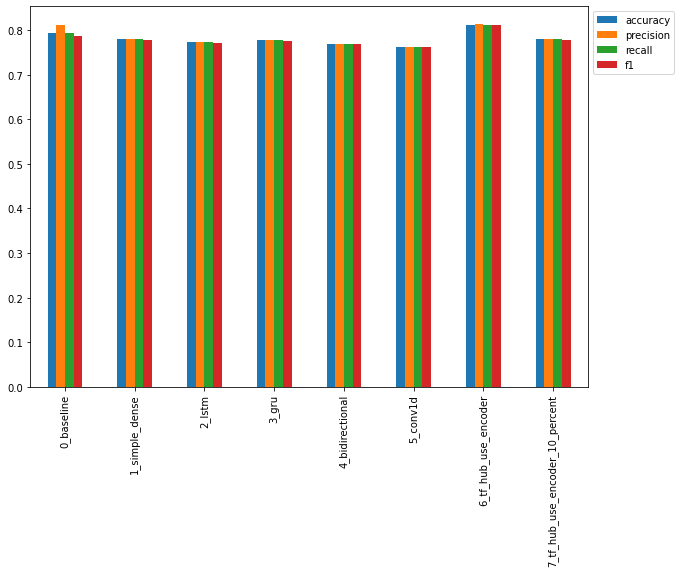

In [117]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

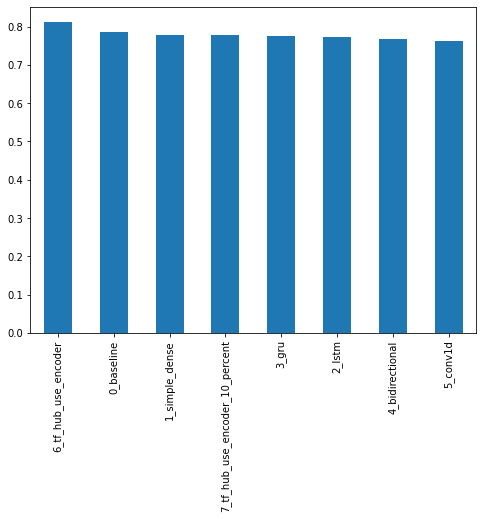

In [118]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(8,6))

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [119]:
# # View tensorboard logs of transfer learning modelling experiments (plus other models)
# # Upload tensorboard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modelling Experiments" \no
#   --description "Comparing multiple different types of model architecture on Kaggle's Tweets text classification dataset" \
#   --one_shot # exit the uploader once uploading is finished

2021-11-22 10:45:43.864096: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


I've run my cell above, my modelling experiments are visible on Tensorboard.dev: https://tensorboard.dev/experiment/SooxYrGgR12U4SrqaIZekw/

TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out **weights & biases**: https://wandb.ai/site

In [120]:
# gives list of tensorboard dev experiments we've run
# !tensorboard dev list

In [121]:
# If you need to delete an experiment from Tensorboard, run the following:
# !tensorboard dev delete --experiment_id SooxYrGgR12U4SrqaIZekw

## Saving and loading a trained model

There are two main formats to save a model in Tensorflow:    
* HDF5 format
* `SaveModel` format (default when using tensorflow)

In [122]:
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

In [123]:
# Save TF Hub sentence encoder model to HDF5 format
model_6.save("model_6.h5")

In [124]:
# Load model with custom hub layer (required with HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [125]:
# how does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4244 - accuracy: 0.8123


[0.4244178831577301, 0.8123359680175781]

In [126]:
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

Now let's save to the `SavedModel` format.

In [127]:
# Save TF hub sentence encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [128]:
# Load in a model
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [129]:
# EAvaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4244 - accuracy: 0.8123


[0.4244178831577301, 0.8123359680175781]

## Finding the most wrong examples

* If our best model still isn't perfect, what example is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

For example, if a sample should have a label of 0 but our model predicts a prediction probaility of 0.999 (really close to 1) and vice-versa.

In [130]:
# Download a pretrained model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-11-22 10:59:48--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  76.0MB/s    in 12s     

2021-11-22 11:00:00 (77.5 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [131]:
# Import previously trained model from google storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [132]:
# make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [134]:
# Create dataframe with validation sentences, val labels and best performing  model predictions probailities and labels
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()


,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [135]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)


In [137]:
most_wrong.head()  # false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [139]:
most_wrong.tail() # false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Target labels:    
* `0` = not disaster
* `1` = disaster

In [141]:
# check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:5].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-----



In [142]:
# check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-5:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 1, Pred: 0.0, Prob: 0.043918460607528687
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

Target: 1, Pred: 0.0, Prob: 0.04208683967590332
Text:
I get to smoke my shit in peace

-----

Target: 1, Pred: 0.0, Prob: 0.03899794816970825
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

-----

Target: 1, Pred: 0.0, Prob: 0.03894948959350586
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

-----

Target: 1, Pred: 0.0, Prob: 0.03718581795692444
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

-----



In [143]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making predictions on the test dataset

In [145]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_sentences[:5]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan']

In [146]:
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))  # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("------\n")

Pred: 0, Prob: 0.06460508704185486
Text:
Baby you're like lightning in a bottle

------

Pred: 0, Prob: 0.07505735754966736
Text:
You cut me open and I keep bleeding. #BleedingLove #LeonaLewis #acapella #singer #canadiansingerÛ_ https://t.co/51pfEIlPNK

------

Pred: 0, Prob: 0.036669641733169556
Text:
Trying to get higher in the bathroom at work with my pen b4 I go and demolish my food ??????

------

Pred: 1, Prob: 0.7723401188850403
Text:
Yesterday's #hailstorm! #boston #cambridge http://t.co/HbgYpruvO7 http://t.co/SwtgHLibs2

------

Pred: 0, Prob: 0.365538626909256
Text:
it doesn't really get much better then summer thunder storms wrapped in a blanket. #icouldsitinthismomentforever

------

Pred: 1, Prob: 0.6605819463729858
Text:
@GreenLacey GodsLove &amp; #thankU my sister for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami

------

Pred: 1, Prob: 0.6853218078613281
Text:
The EFAK would be designed for building occupants once they evacua

## The speed/score tradeoff

In [147]:
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

In [148]:
# Let's make a function to measure time of prediction
import time
def pred_timer(model, samples):
  '''
  Times how long a model takes to make predictions on samples.
  '''
  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [149]:
# calculate TF Hub sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained,
                                                            val_sentences)

model_6_total_pred_time, model_6_time_per_pred

(0.2740327139999863, 0.00035962298425195054)

In [150]:
# Calculate our baseline model's time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.0225961650003228, 2.9653759842943305e-05)

In [152]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.23359580052494,
 'f1': 0.8115121319063344,
 'precision': 0.812763224356635,
 'recall': 0.8123359580052494}

Text(0, 0.5, 'F1-Score')

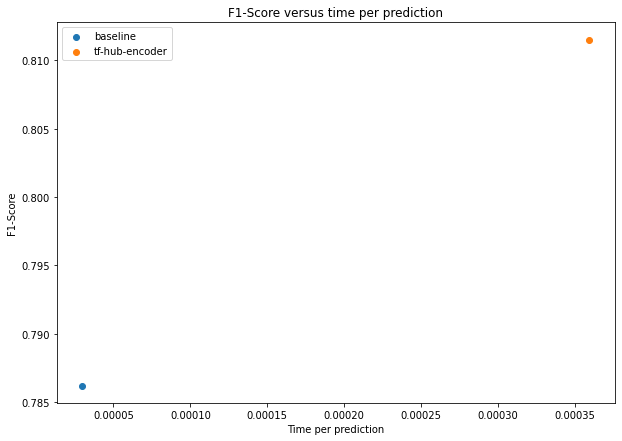

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf-hub-encoder")
plt.legend()
plt.title("F1-Score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score")